In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import clear_output

import tensorflow as tf

In [ ]:
start = 0
end = 100000

range_values = np.arange(start, end)

# Create the digit representation as a 2D array
X = np.array([list(map(int, str(x).zfill(15))) for x in range_values])

# Create the labels using vectorized operations
y = np.column_stack((range_values % 2, (range_values + 1) % 2))

# Split data up into training and validation data.
split_train = StratifiedShuffleSplit(n_splits=3, test_size=0.4, train_size=0.6)
for train_index, test_index in split_train.split(X, y):
    X_val, X_train = X[test_index], X[train_index]
    y_val, y_train = y[test_index], y[train_index]

In [ ]:
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_frequency):
        super(CustomLoggingCallback, self).__init__()
        self.log_frequency = log_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_frequency == 0:
            print(f'Epoch {epoch + 1}: {logs}')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(70, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model.evaluate(X_train, y_train)

In [ ]:
#model.evaluate(X_val, y_val)

In [ ]:
log_frequency = 100
custom_callback = CustomLoggingCallback(log_frequency)

model.fit(X_train, y_train, batch_size=512, epochs=1000, validation_data=(X_val, y_val), callbacks=[custom_callback] ,verbose=0)

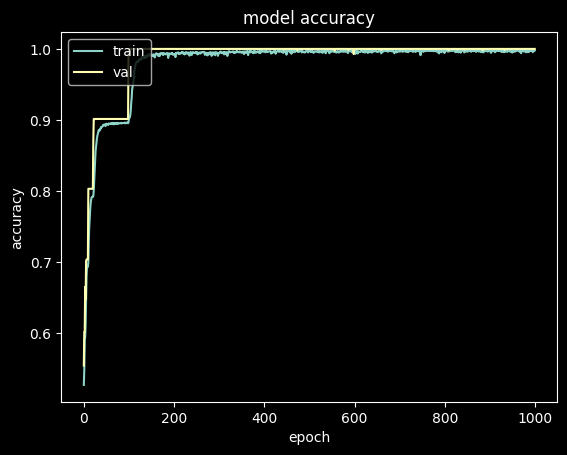

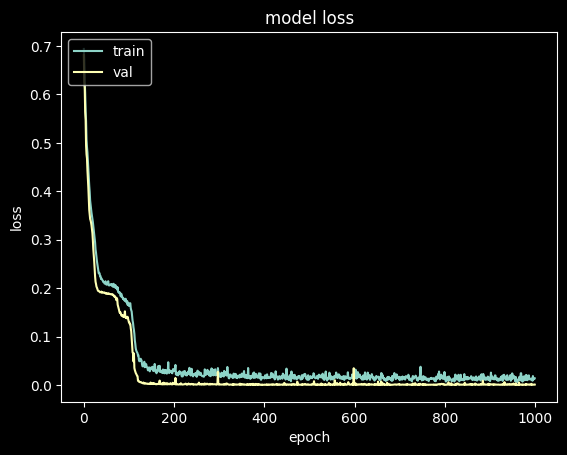

In [ ]:
plt.style.use('dark_background')

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(f"maximum accurary of '{max(model.history.history['val_accuracy'])}' at epoch number {model.history.history['val_accuracy'].index(max(model.history.history['val_accuracy']))}")
print(f"mimimum loss of '{min(model.history.history['val_loss'])}' at epoch number {model.history.history['val_loss'].index(min(model.history.history['val_loss']))}")

maximum accurary of '1.0' at epoch number 100
mimimum loss of '0.00021344887500163168' at epoch number 815


In [ ]:
model.save('model.keras')

In [ ]:
def num_to_nparray(num):
    return np.array([list(map(int, str(num).zfill(15)))])

In [ ]:
def predict_odd(num):
    prediction = model.predict(num_to_nparray(num))
    return prediction[0][0] > prediction[0][1]

In [ ]:
#model.predict(num_to_nparray(32))

In [ ]:
#predict_odd(33)

In [ ]:
#import_model = tf.keras.models.load_model('model.keras')

In [ ]:
#import_model.predict(num_to_nparray(100006))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([[0.8536383 , 0.14635983]], dtype=float32)

### Testing


In [ ]:
model = tf.keras.models.load_model('model.keras')

def num_to_nparray(num):
    return np.array([list(map(int, str(num).zfill(15)))])

def predict_odd(num):
    prediction = model.predict(num_to_nparray(num), verbose=0)
    return prediction[0][0] > prediction[0][1]

for i in range(1_000_000_000_000_000):
    # log every 1 million, clear every 50 million
    if i%1_000_000 == 0:
      print(f"at number {i}")
    if i%50_000_000 == 0:
      clear_output(wait=True)
      print(f"at number {i}")

    predict = predict_odd(i)
    correct = bool(i%2)
    if( predict != correct):
        print(f"error at number {i}, should be {correct}, predicted {predict}")
        break

at number 0
at number 0
error at number 100006, should be False, predicted True
